# NN rruff DataBase For Powder Difraction X-Ray

### Creating the tensor DataSet and Labels

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [4]:
# Finding the Data Directory
data_dir = '/content/drive/My Drive/ML_rruff'
os.chdir(data_dir)

# List the contents of the directory
print(os.listdir())

print("------------")

os.chdir('XY_Processed')
dirs = os.listdir()
print(dirs)

['XY_Processed', 'EX1', 'Selected', 'DataSet.ipynb', 'NN.ipynb', 'NN_Pro.ipynb']
------------
['Diamond__R050207-9__Powder__Xray_Data_XY_Processed__7229.txt', 'Diaoyudaoite__R050182-9__Powder__Xray_Data_XY_Processed__6935.txt', 'Diaphorite__R060173-9__Powder__Xray_Data_XY_Processed__2352.txt', 'Diaspore__R060546-1__Powder__Xray_Data_XY_Processed__3677.txt', 'Diaspore__R060287-1__Powder__Xray_Data_XY_Processed__2783.txt', 'Dickite__R060298-1__Powder__Xray_Data_XY_Processed__2779.txt', 'Dickite__R090054-1__Powder__Xray_Data_XY_Processed__10128.txt', 'Dietrichite__R070381-1__Powder__Xray_Data_XY_Processed__8417.txt', 'Digenite__R060840-1__Powder__Xray_Data_XY_Processed__6871.txt', 'Diopside__R040009-1__Powder__Xray_Data_XY_Processed__2567.txt', 'Diopside__R040097-1__Powder__Xray_Data_XY_Processed__3420.txt', 'Diopside__R050406-1__Powder__Xray_Data_XY_Processed__5733.txt', 'Diopside__R050496-1__Powder__Xray_Data_XY_Processed__1811.txt', 'Diopside__R050666-1__Powder__Xray_Data_XY_Processed_

In [5]:
# Get Data Function

def get_data(file_path):
    # Read the data from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the data points
    data = []
    metadata = []
    for line in lines:
        if line.startswith('##'):
            metadata.append(line.strip())
        else:
            try:
                x, y = map(float, line.strip().split(','))
                data.append((x, y))
            except ValueError:
                #print(f"Warning: Skipping invalid data: '{line.strip()}'")
                pass

    if not data:
        print("Error: No valid data points found in the file.")
        return


    #print(x_values)

    # Separate x and y values
    x_values, y_values = zip(*data)
    return x_values, y_values

x_values, y = get_data(dirs[0])
print(len(x_values))



8501


In [21]:
def prepare_labels_for_cross_entropy(labels, all_labels):
    # Create a dictionary mapping each unique label to a unique integer
    label_to_index = {label: idx for idx, label in enumerate(set(all_labels))}

    # Convert labels to their corresponding integers
    label_indices = [label_to_index[label] for label in labels]

    # Convert to tensor
    label_indices_tensor = torch.tensor(label_indices, dtype=torch.long)

    # Create one-hot encoded tensor
    num_classes = len(label_to_index)
    one_hot_labels = F.one_hot(label_indices_tensor, num_classes=num_classes)

    return one_hot_labels, label_indices_tensor, label_to_index


In [ ]:
def process_all_files_in_directory(n=5):
    data_list = []
    all_labels = []

    directory_path = os.getcwd()
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]

    for file_name in txt_files:
        file_path = os.path.join(directory_path, file_name)
        x_values, y_values = get_data(file_path)

        if len(x_values) != 8501:
            continue

        filename = os.path.basename(file_path)
        label = filename.split('__')[0]

        data_list.append(np.array(y_values))
        all_labels.append(label)

    return data_list, all_labels

# Usage
data_list, labels = process_all_files_in_directory()

# Convert to numpy arrays
data_array = np.array(data_list)
labels_array = np.array(labels)

# Create a random permutation of indices
indices = np.random.permutation(len(data_array))

# Calculate split index
split_idx = int(len(data_array) * 0.9)  # 90% for training

# Split the data
train_data = data_array[indices[:split_idx]]
train_labels = labels_array[indices[:split_idx]]
test_data = data_array[indices[split_idx:]]
test_labels = labels_array[indices[split_idx:]]

# Add noisy versions to training data
def add_noise(spectrum, noise_level=0.01):
    return spectrum + np.random.normal(0, noise_level, spectrum.shape)

noisy_train_data = []
noisy_train_labels = []
for spectrum, label in zip(train_data, train_labels):
    noisy_train_data.append(spectrum)
    noisy_train_labels.append(label)
    for _ in range(5):  # Add 5 noisy versions
        noisy_spectrum = add_noise(spectrum)
        noisy_train_data.append(noisy_spectrum)
        noisy_train_labels.append(label)

# Convert to tensors
train_data_tensor = torch.tensor(noisy_train_data, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)

print(f"Training set size: {len(train_data_tensor)}")
print(f"Testing set size: {len(test_data_tensor)}")

# Prepare labels for cross-entropy
train_one_hot_labels, train_label_indices, label_to_index = prepare_labels_for_cross_entropy(noisy_train_labels, labels)
test_one_hot_labels, test_label_indices, _ = prepare_labels_for_cross_entropy(test_labels, labels)

print(f"One-hot labels shape: {train_one_hot_labels.shape}")
print(f"Label indices shape: {train_label_indices.shape}")


In [8]:
print(f"Final data tensor shape: {data_tensor.shape}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {len(set(labels))}")
output_p = (list(set(labels)))
print(output_p)

Final data tensor shape: torch.Size([7692, 8501])
Number of labels: 7692
Unique labels: 756
['Portlandite', 'Ilmenite', 'Gowerite', 'HeulanditeCa', 'Bobdownsite', 'Piemontite', 'Pentahydrite', 'Huntite', 'Jeremejevite', 'Celestine', 'Svanbergite', 'PumpellyiteMg', 'ThomsoniteCa', 'Nepheline', 'Emeleusite', 'BastnasiteCe', 'Tremolite', 'Hedenbergite', 'Orthoclase', 'Connellite', 'Serendibite', 'Davyne', 'Vuagnatite', 'Romeite', 'Pharmacoalumite', 'Bayldonite', 'Hematite', 'Marcasite', 'Jarosite', 'Schultenite', 'Cinnabar', 'ArrojaditeKFe', 'Antimony', 'Phenakite', 'Claudetite', 'Otavite', 'Zeophyllite', 'Kernite', 'Fiedlerite', 'Manganilvaite', 'Henritermierite', 'Manganomanganiungarettiite', 'Paradamite', 'Ferroactinolite', 'Spangolite', 'Merwinite', 'GarroniteCa', 'Brizziite', 'Talc', 'Zinkenite', 'Gold', 'Baumhauerite', 'Bournonite', 'Linarite', 'Satterlyite', 'Natrolite', 'Gypsum', 'Edoylerite', 'Wolfeite', 'Pyrophyllite', 'Bellingerite', 'Tiemannite', 'Eglestonite', 'Stichtite', 'A

-------------
Diamond


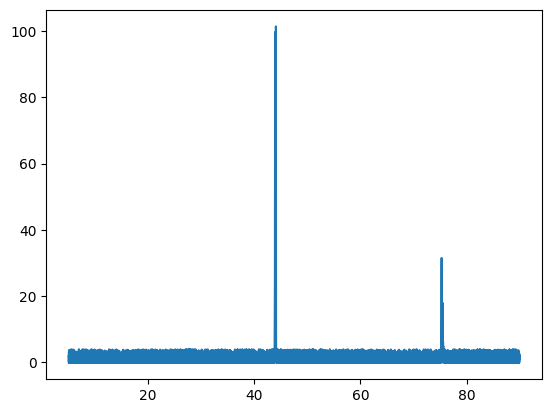

In [9]:
# Plotting an Example

plt.plot(x_values, data_tensor[1])
print("-------------")
print(labels[1])

In [10]:
# Get the number of samples
num_samples = data_tensor.shape[0]

# Create a random permutation of indices
indices = torch.randperm(num_samples)

# Shuffle the data_tensor
shuffled_data = data_tensor[indices]

# Shuffle the labels list using the same indices
shuffled_labels = [labels[i] for i in indices.tolist()]

# Calculate split index
split_idx = int(num_samples * 0.9)  # 90% for training

# Split the data
train_data = shuffled_data[:split_idx]
test_data = shuffled_data[split_idx:]

# Split the labels
train_labels = shuffled_labels[:split_idx]
test_labels = shuffled_labels[split_idx:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 6922
Testing set size: 770


#--------------------------------------------
# Creating the NN

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:

import torch
import torch.nn.functional as F

def prepare_labels_for_cross_entropy(labels, all_labels):
    # Create a dictionary mapping each unique label to a unique integer
    label_to_index = {label: idx for idx, label in enumerate(set(all_labels))}

    # Convert labels to their corresponding integers
    label_indices = [label_to_index[label] for label in labels]

    # Convert to tensor
    label_indices_tensor = torch.tensor(label_indices, dtype=torch.long)

    # Create one-hot encoded tensor
    num_classes = len(label_to_index)
    one_hot_labels = F.one_hot(label_indices_tensor, num_classes=num_classes)

    return one_hot_labels, label_indices_tensor, label_to_index

# Usage
#Alredy run...
#data_tensor, labels = process_all_files_in_directory(n=5)
one_hot_labels, label_indices, label_to_index = prepare_labels_for_cross_entropy(train_labels, train_labels)

print(f"One-hot labels shape: {one_hot_labels.shape}")
print(f"Label indices shape: {label_indices.shape}")



One-hot labels shape: torch.Size([6922, 756])
Label indices shape: torch.Size([6922])


In [13]:
print(one_hot_labels[0])
print(label_indices[0])
print(label_to_index)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
W1 = torch.randn((8501, 800), generator=g)
b1 = torch.randn(800, generator=g)
W2 = torch.randn((800, 28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [W1, b1, W2, b2]
print(f"The NN has: {(sum(p.nelement() for p in parameters))} parameters" )

The NN has: 6824028 parameters


In [15]:
for p in parameters:
  p.requires_grad = True

AttributeError: 'function' object has no attribute 'shape'

In [17]:
while True:
    # forward pass
    h = torch.tanh(train_data @ W1 + b1)
    logits = h @ W2 + b2

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=1)

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(logits, label_indices)

    print(f"The loss is: {loss}")
    if loss < 10e-3:
        print(f"Reached Stop Point!!")
        break

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

IndexError: Target 114 is out of bounds.

Predicted label: Enstatite
Expected label: Enstatite
Probability: 1.0000


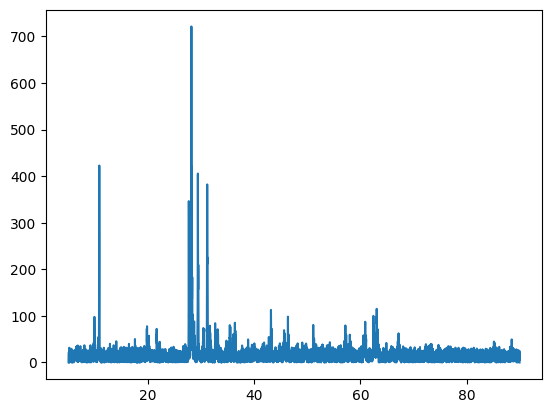

In [ ]:

index_to_label = {v: k for k, v in label_to_index.items()}  # Reverse the dictionary


def test_example(i):
  # For a single example (the first one in data_tensor)
  h = torch.tanh(test_data[i] @ W1 + b1)
  logits = h @ W2 + b2

  # Apply softmax to get probabilities
  probabilities = F.softmax(logits, dim=0)  # Note: dim=0 for a single example
  #print("Probabilities:", probabilities)
  max_prob_index = torch.argmax(probabilities).item()
  #print(max_prob_index)

  predicted_label = index_to_label[max_prob_index]

  print(f"Predicted label: {predicted_label}")
  print(f"Expected label: {test_labels[i]}")
  print(f"Probability: {probabilities[max_prob_index].item():.4f}")

test_example(10)
plt.plot(x_values, test_data[10])